In [62]:
import requests, json, pandas as pd, numpy as np
import time
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.linear_model import MultiTaskLassoCV, LassoCV
import math
from sklearn.cross_validation import train_test_split
import rpy2.robjects as ro
%matplotlib inline

The basic premise: Brilliant Earth is a purveyor of ethically sourced, non-conflict diamonds... or so they claim. There are a dizzying number of combinations of diamond qualities (Color, Cut, Carat, Clarity, Shape) and it's unclear how these all relate to the final price of the diamond. My goal was to develop a multiple linear regression to determine the relationship between the 4Cs and the price of the diamond.

Luckily Brilliant Earth's API is public and reasonably well maintained (and doesn't include any rate-limiting). Getting the  API URL and response structure is trivial, as was the regression modeling. There are also well documented  libraries in Python to quickly conduct linear regression and output model characteristics. Note - the goal for this was *not* prediction of price, only inference and learning.

Future applicaitons might consider more advanced statistical methods, but didn't have time for that before sharing.

## Data Extraction and Cleaning

In [2]:
#Brilliant Earth API call. Some filtering based on my original search, but this pulls about 5000 of BE's diamonds. Can easily use the dev tools setting in chrome to find out where this is. Not going to document here.

url_round = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Round&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_oval = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Oval&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_asscher = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Asscher&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_cushion = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Cushion&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_princess = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Princess&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_pear = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Pear&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_emerald = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Emerald&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_marquise = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Marquise&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=0.5&max_carat=18.75&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=530&max_price=2559240&stock_number=&row=0&page=1&requestedDataSize=10000&order_by=price&order_method=asc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=530&MAX_PRICE=2559240&MIN_CARAT=0.25&MAX_CARAT=18.75&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"
url_list = [url_oval,url_asscher,url_cushion,url_princess,url_pear, url_emerald, url_marquise,url_round]
#url = "http://www.brilliantearth.com/loose-diamonds/list/?shapes=Oval&cuts=Fair%2CGood%2CVery+Good%2CIdeal%2CSuper+Ideal&colors=J%2CI%2CH%2CG%2CF%2CE%2CD&clarities=SI2%2CSI1%2CVS2%2CVS1%2CVVS2%2CVVS1%2CIF%2CFL&polishes=Good%2CVery+Good%2CExcellent&symmetries=Good%2CVery+Good%2CExcellent&fluorescences=Very+Strong%2CStrong%2CMedium%2CFaint%2CNone&min_carat=1.00&max_carat=2.51&min_table=45.00&max_table=85.00&min_depth=0.00&max_depth=83.10&min_price=720&max_price=25000&stock_number=&row=0&requestedDataSize=100&order_by=price&order_method=desc&currency=%24&min_ratio=1.00&max_ratio=2.75&shipping_day=&MIN_PRICE=720&MAX_PRICE=226620&MIN_CARAT=0.3&MAX_CARAT=5.06&MIN_TABLE=45&MAX_TABLE=85&MIN_DEPTH=0&MAX_DEPTH=83.1"

The JSON response is poorly formatted, so instead of grabbing the "results" item, the below code grabs the "diamonds" item, which contains a JSON document for each diamond in Brilliant Earth's inventory.


After separating the JSON into just the 'diamond' documents, I loop through and grab each of the quantities of diamond characteristics including: 
- carat size
- price
- clarity (using the common diamond clarity scale)
- color (using the common diamond color scale)
- cut (using the common diamond cut scale)
- shape (10 different diamond shapes)

In [3]:
carat = list()
price = list()
clarity = list()
color = list()
cut = list()
shape = list()
for u in url_list:
    r = requests.get(u,timeout=1000)
    data = json.loads(r.text)
    diamonds = data['diamonds']
    for i in diamonds:
        carat.append(i['carat'])
        price.append(i['price'])
        clarity.append(i['clarity'])
        color.append(i['color'])
        cut.append(i['cut'])
        shape.append(i['shape'])
    

Next we create a dataframe with all of the characteristics. Note that I modified the "cut"variable in order to eliminate spaces in the multi-word values. This was important to make sure the get_dummies() function created data frame column names that would be interpretable by the Statsmodel functions I used later.

In [5]:
df = pd.DataFrame({"carat": carat,
                   "price" : price,
                   "clarity" : clarity,
                   "color" : color,
                   "cut" : cut,
                   "shape" : shape})
df['cut'] = df['cut'].apply(cut_to_dummy)
df.head()
df.shape

(14903, 6)

~15K diamonds in the training dataset. Not bad, though something with the API is limiting the number of results I can grab at a time. This might bias the sample with the round diamonds in particular, as that dataset makes up by far the largest portion.

In [6]:
df.head()

,carat,clarity,color,cut,price,shape
0,0.55,SI1,J,Good,1030,Oval
1,0.51,VS1,J,Fair,1060,Oval
2,0.51,SI1,I,Very_Good,1100,Oval
3,0.50,SI2,F,Fair,1190,Oval
4,0.50,SI1,H,Ideal,1210,Oval


In [8]:
data_for_regression = pd.get_dummies(df)
data_for_regression.drop(['clarity_SI2', 'color_H', 'cut_Fair','shape_Round'], axis = 1, inplace = True)
pricedata = pd.DataFrame.from_dict(data_for_regression['price'])
data_for_regression.drop(['price'],axis=1,inplace=True)
data_for_regression.columns
pricedata.head()

,price
0,1030
1,1060
2,1100
3,1190
4,1210


In [10]:
pricedata.head()

,price
0,1030
1,1060
2,1100
3,1190
4,1210


## Profiling

In [75]:
#Outlier removal - 3 stdev away from the mean is dropped
z = df[(np.abs(df.price-df.price.mean())<=(3*df.price.std()))]
z.shape

(14743, 6)

In [81]:
z.describe()

,carat,price
count,14743.000000,14743.000000
mean,0.735685,3770.019670
std,0.364735,3913.176215
min,0.500000,990.000000
25%,0.510000,2120.000000
50%,0.610000,2750.000000
75%,0.800000,3875.000000
max,4.030000,40290.000000


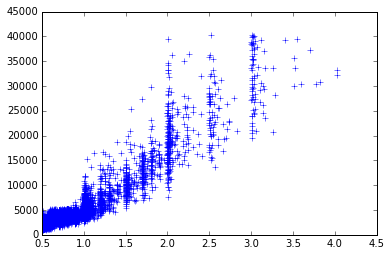

In [87]:
plt.plot(z['carat'],z['price'],'+')

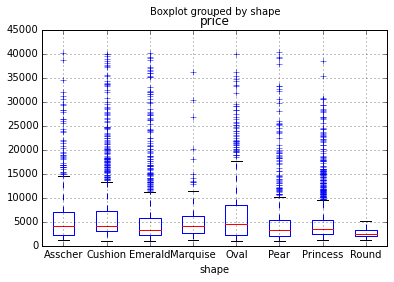

In [72]:
z.boxplot('price',by='shape')

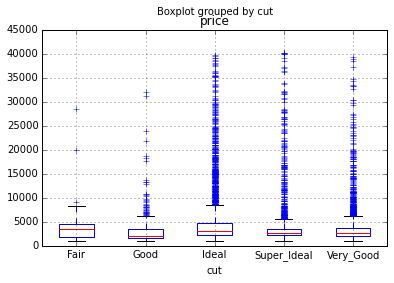

In [73]:
z.boxplot('price',by='cut')

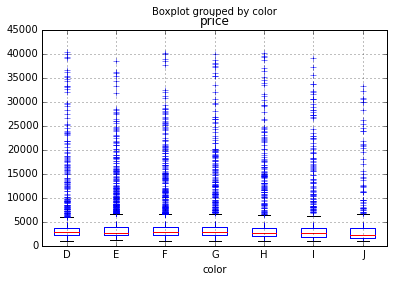

In [74]:
z.boxplot('price',by='color')

## Lasso with Cross Validation (outliers removed)

In [94]:
data_for_regression = pd.get_dummies(z)
data_for_regression.drop(['clarity_SI2', 'color_H', 'cut_Fair','shape_Round'], axis = 1, inplace = True)
pricedata = pd.DataFrame.from_dict(data_for_regression['price'])
data_for_regression.drop(['price'],axis=1,inplace=True)
data_for_regression.columns
pricedata.head()

,price
0,1030
1,1060
2,1100
3,1190
4,1210


In [95]:
start_time = time.time()
model = MultiTaskLassoCV(cv=10,fit_intercept=True).fit(data_for_regression,pricedata.values)
end_time = time.time()
runtime=end_time-start_time
print(runtime)

14.304561138153076


In [96]:
a = pd.DataFrame(data=model.coef_, columns = data_for_regression.columns.values )
a.transpose()

,0
carat,11327.387630
clarity_FL,2785.000788
clarity_IF,2341.706439
clarity_SI1,635.639509
clarity_VS1,1263.556756
clarity_VS2,1048.742876
clarity_VVS1,1770.570740
clarity_VVS2,1425.472695
color_D,1088.602766
color_E,757.050440


Commentary: None of the coefficients actually shrank to zero. Hmm..... Similar results to the OLS results below (no cross validation).

## OLS Regressions (removed outliers)

In [91]:
data_for_regression = pd.get_dummies(z)
data_for_regression.drop(['clarity_SI2', 'color_H', 'cut_Fair','shape_Round'], axis = 1, inplace = True)
data_for_regression.head()

,carat,price,clarity_FL,clarity_IF,clarity_SI1,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,...,cut_Ideal,cut_Super_Ideal,cut_Very_Good,shape_Asscher,shape_Cushion,shape_Emerald,shape_Marquise,shape_Oval,shape_Pear,shape_Princess
0,0.55,1030,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.51,1060,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.51,1100,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0.50,1190,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.50,1210,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


Create dummy variables for the categorical variables: clarity, color, cut, shape. I dropped one of each category in order to make the coefficients more meaningful.

Created a standard OLS regression using the ols function of the statsmodels library. Note that I used a several interaction terms as well as a quadratic term on carat size. Observations:
+ carat size matters **immensely**
+ huge jump between F color and the better ones (D&E).
+ Round diamonds command a sizable premium over every other kind of shape ('Round' was the ommitted dummy for the shape categorical variable).

Fidelity of results:
+ Everything came through as significant, which is a bit worrisome.
+ solid adjusted R^2 even with 21 degrees of freedom.
+ good F statistic values (I think)

My conclusions for this: Avoid round diamonds. If you need to make a tradeoff you can probably skimp on color (anyone who can tell the difference between D and E is a liar and you should call them out on it). 

In [93]:
lm_outliers_removed = smf.ols(formula= 'price ~ carat \
                        + clarity_IF + clarity_SI1 + clarity_VS1 + clarity_VS1 + clarity_VVS1 + clarity_VVS2 \
                        + color_D +color_E + color_F + color_G \
                        + cut_Good + cut_Very_Good + cut_Ideal + cut_Super_Ideal \
                        + shape_Asscher + shape_Cushion + shape_Emerald + shape_Marquise \
                        + shape_Oval + shape_Pear + shape_Princess' , data=data_for_regression).fit()
lm_outliers_removed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     6701.
Date:                Sat, 04 Jun 2016   Prob (F-statistic):               0.00
Time:                        20:31:02   Log-Likelihood:            -1.2550e+05
No. Observations:               14743   AIC:                         2.510e+05
Df Residuals:                   14721   BIC:                         2.512e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -6097.7087    113.345    -53.798      0.000     -6319.880 -5875.538
carat            1.129e+04     33.563    336.395      0.000      1.12e+04  1.14e+04
clarity_IF       1625.8368     62.695     25.932      0.000      1502.947  1748.727
clarity_SI1      -116.6332     28.996     -4.022      0.000      -173.468   -59.798
clarity_VS1       506.5748     27.931     18.137      0.000       451.827   561.323
clarity_VVS1      998.9638     36.232     27.571      0.000       927.944  1069.984
clarity_VVS2      671.0460     31.019     21.633      0.000       610.244   731.848
color_D          1611.2825     32.812     49.106      0.000      1546.967  1675.598
color_E          1263.1090     29.281     43.138      0.000      1205.715  1320.503
color_F          1061.8081     29.349     36.178      0.000      1004.280  1119.336
color_G           770.4060     30.885     24.944      0.000       709.868   830.945
cut_Good          469.0588    116.739      4.018      0.000       240.236   697.882
cut_Very_Good     743.0034    109.740      6.771      0.000       527.899   958.108
cut_Ideal         807.7369    110.305      7.323      0.000       591.525  1023.949
cut_Super_Ideal   998.7734    109.753      9.100      0.000       783.643  1213.904
shape_Asscher   -1624.7190     69.006    -23.545      0.000     -1759.980 -1489.458
shape_Cushion   -2006.3439     48.264    -41.571      0.000     -2100.947 -1911.741
shape_Emerald   -1630.1276     46.934    -34.732      0.000     -1722.125 -1538.130
shape_Marquise  -1260.1271    113.146    -11.137      0.000     -1481.908 -1038.346
shape_Oval       -552.4339     63.642     -8.680      0.000      -677.181  -427.687
shape_Pear       -931.8762     51.620    -18.053      0.000     -1033.057  -830.695
shape_Princess  -1443.4809     37.771    -38.217      0.000     -1517.516 -1369.446
==============================================================================
Omnibus:                    12431.116   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1110314.628
Skew:                           3.553   Prob(JB):                         0.00
Kurtosis:                      44.916   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The below represents some sandbox work I've been doing to do some cross validation and explore the effect of chunking the dataset into test and training parts. Was specifically interested in MSE as a function of test/train split size. Kinda funky results, but generally what I expected.

**NOTE**: I would modify the range size if you are working on a slower machine. I ran each regression a thousand times but you could probably get away with much, much less.

In [130]:
X = data_for_regression.drop('price', axis = 1)
y = data_for_regression['price']
test_size_range = list(np.arange(0.05,1,0.05))
answer_list = list()

for t in test_size_range:
    for i in range(0,1000):
        test_list = list()
        for_analysis = pd.DataFrame()
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= t)
        test_results = smf.OLS(y_train, X_train).fit()
        y_test_predict = test_results.predict(X_test)
        for_analysis = pd.DataFrame({'y_test' : y_test, 
                                 'y_test_hat' : y_test_predict})
        for_analysis['error'] = for_analysis['y_test_hat'] - for_analysis['y_test']
        n = len(for_analysis.index)
        for_analysis['Squared Error'] = for_analysis['error']**2
        MSE = sum(for_analysis['Squared Error']) / n
        test_list.append(MSE)
    ans = sum(test_list) / len(test_list)
    answer_list.append(ans)

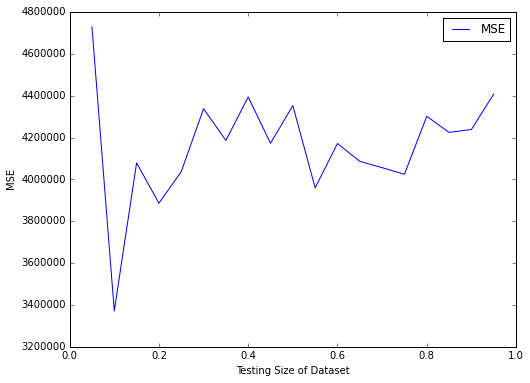

In [131]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_size_range, answer_list, 'b-', label = 'MSE')
plt.xlabel('Testing Size of Dataset')
plt.ylabel('MSE')
ax.legend(loc='best')

Trying to execute a similar process for the blue nile website. Their API is super f-cking clunky and I haven't made much progress.

In [4]:
start_pos = 0
page_results = 1000
n_total = 162500
n_max = math.floor(n_total/page_results)


color_bn = list()
cut_bn = list()
price_bn = list()
clarity_bn = list()
carat_bn = list()


#for i in range(0,3):
#   url_blue_nile = "http://www.bluenile.com/api/public/build-your-own-ring/diamond-search-grid/solr?country=USA&language=en-us&currency=USD&startIndex=" + str(10000) + "&pageSize=" + str(page_results) + "&sortColumn=price&sortDirection=asc&_=1456107481571"
#    r = requests.get(url_blue_nile)
#    data = json.loads(r.text)
#    data = data['results']
#    for j in data:
#        carat_bn.append(j['carat'])
#    data = []
#diamonds = data['diamonds']
#data_test = json.loads(r.text)
#data_test = data_test['diamonds']
#data = data['results']
#data

In [4]:
#Created a quick mapping so that the cut categorical variables would map correctly when using the .get_dummies function from pandas.
    
def cut_to_dummy(x):
    if x == "Very Good":
        return "Very_Good"
    if x == "Super Ideal":
        return "Super_Ideal"
    else:
        return x

In [100]:
$jupyter nbconvert "Explorations in diamond pricing.ipynb"

SyntaxError: invalid syntax (<ipython-input-100-55a6417a05e0>, line 1)